# Fast, Simple Calcium Imaging Segmentation with Fully Convolutional Networks

- Figures, tables, etc.
- High-quality figures get saved to the `notebooks` directory when you execute their cells.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from __future__ import print_function
from glob import glob
from scipy.misc import imread, imsave
from keras.models import load_model
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import sys
import h5py
import os
from IPython.display import Image
from skimage import measure

sys.path.append('..')
from deepcalcium.datasets.nf import nf_load_hdf5, nf_mask_metrics
from deepcalcium.utils.neurons import mask_outlines, series_kmeans_summary
from deepcalcium.models.neurons.unet_2d_summary import UNet2DSummary, _summarize_mask, _summarize_series
from deepcalcium.utils.keras_helpers import load_model_with_new_input_shape

# Choose CPU/GPU for predictions.
# os.environ['CUDA_VISIBLE_DEVICES'] = ""  # CPU
os.environ['CUDA_VISIBLE_DEVICES'] = "1"   # GPU

# Latest greatest model.
MODEL_PATH = '../checkpoints/neurons_unet2ds/neurons_unet2ds.hdf5'

print('Done')

Using TensorFlow backend.


Done


In [4]:
# How many frames and neurons in the neurofinder dataset?
nb_frms, nb_nrns = 0., 0.
for dsp in nf_load_hdf5('all_train'):
    fp = h5py.File(dsp)
    nb_frms += fp.get('series/raw').shape[0]
    nb_nrns += fp.get('masks/raw').shape[0]
    fp.close()
    
print('Training: %d frames, %d neurons.' % (nb_frms, nb_nrns))

Training: 66017 frames, 6974 neurons.


In [5]:
# Quantify raw-pixel variability and class-imbalance in neurofinder training datasets.
# This takes ~10 minutes to run assuming all data is downloaded and converted to HDF5 already.
mean_pix, prop_pos = [], []
for dsp in nf_load_hdf5('all'):
    fp = h5py.File(dsp)
    mean_pix.append(np.mean(fp.get('series/raw')[...]))
    if 'masks/max' in fp:
        m = fp.get('masks/max')
        prop_pos.append((np.sum(m) * 1. / m.size))
    fp.close()
print(sorted(mean_pix))
print('Mean positive proportion', np.mean(prop_pos))

[57.720553920226379, 61.765766714530564, 66.018713287353521, 67.003386747922832, 67.193527621746057, 76.131589087486262, 76.228727905908585, 76.90831238508224, 84.146768393687978, 86.87979550131648, 91.754769399130382, 93.596567586263021, 98.164024522145596, 100.38523596726455, 103.17039340816973, 130.1122618296512, 140.74772518666586, 148.92887419382731, 161.84386868614538, 183.38195631239148, 432.58933281049337, 510.38683423156738, 1284.7237856330871, 1303.4977871704102, 1486.8210885645549, 1555.7998805557706, 1845.9729298027887, 2998.0946010017392]
Mean positive proportion 0.125978616712


HNCcorr \cite{spaen2017hnccorr} + Conv2d \cite{conv2d} & \hspace{0.1cm} $0.617 \pm0.122$ \hspace{0.1cm} & \hspace{0.1cm}$ 0.702 \pm0.170$ \hspace{0.1cm} & \hspace{0.1cm} $0.602 \pm0.197$ \hspace{0.1cm} \\ \hline
Sourcery \cite{sourcery} & \hspace{0.1cm} $0.583 \pm0.139$ \hspace{0.1cm} & \hspace{0.1cm}$ 0.599 \pm0.197$ \hspace{0.1cm} & \hspace{0.1cm} $0.629 \pm0.168$ \hspace{0.1cm} \\ \hline
UNet2DS & \hspace{0.1cm} $0.569 \pm0.160$ \hspace{0.1cm} & \hspace{0.1cm}$ 0.618 \pm0.235$ \hspace{0.1cm} & \hspace{0.1cm} $0.609 \pm0.185$ \hspace{0.1cm} \\ \hline
Suite2p \cite{pachitariu2016suite2p} + Donuts \cite{pachitariu2013extracting} & \hspace{0.1cm} $0.550 \pm0.127$ \hspace{0.1cm} & \hspace{0.1cm}$ 0.578 \pm0.156$ \hspace{0.1cm} & \hspace{0.1cm} $0.568 \pm0.181$ \hspace{0.1cm} \\ \hline
HNCcorr \cite{spaen2017hnccorr} & \hspace{0.1cm} $0.492 \pm0.180$ \hspace{0.1cm} & \hspace{0.1cm}$ 0.618 \pm0.169$ \hspace{0.1cm} & \hspace{0.1cm} $0.479 \pm0.268$ \hspace{0.1cm} \\ \hline


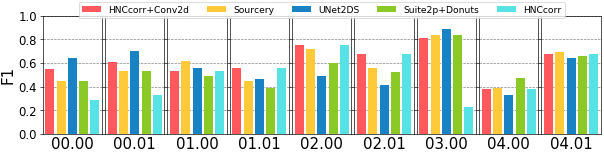

In [3]:
# Table and figure for Neurofinder results. 
# Each set of lists is the combined score, recall scores, and precision scores.
dsids = ['00.00', '00.01', '01.00', '01.01', '02.00', '02.01', '03.00', '04.00', '04.01']
results = [
('HNCcorr \cite{spaen2017hnccorr} + Conv2d \cite{conv2d}',
 'HNCcorr+Conv2d', [
    [0.55, 0.61, 0.53, 0.56, 0.75, 0.68, 0.81, 0.38, 0.68], # F1
    [0.43, 0.51, 0.39, 0.42, 0.94, 0.89, 0.76, 0.50, 0.58], # Recall
    [0.75, 0.76, 0.80, 0.84, 0.62, 0.55, 0.86, 0.31, 0.83]  # Precision
]),
('Sourcery \cite{sourcery}',
 'Sourcery', [
    [0.45, 0.53, 0.62, 0.45, 0.72, 0.56, 0.84, 0.39, 0.69],
    [0.37, 0.44, 0.52, 0.68, 0.85, 0.81, 0.85, 0.57, 0.57],
    [0.58, 0.67, 0.77, 0.34, 0.62, 0.43, 0.83, 0.29, 0.86]
]),
('UNet2DS', 'UNet2DS', [
    [0.64, 0.70, 0.56, 0.46, 0.49, 0.41, 0.89, 0.33, 0.64],
    [0.52, 0.60, 0.45, 0.37, 0.83, 0.79, 0.93, 0.43, 0.56],
    [0.84, 0.84, 0.76, 0.62, 0.35, 0.28, 0.85, 0.27, 0.75]
]),
# ('UNet2DS', 'UNet2DS', [
#     [0.63, 0.68, 0.53, 0.46, 0.48, 0.41, 0.88, 0.33, 0.65],
#     [0.54, 0.61, 0.45, 0.40, 0.86, 0.83, 0.93, 0.47, 0.58],
#     [0.77, 0.77, 0.65, 0.56, 0.33, 0.28, 0.83, 0.26, 0.72]
# ]),
('Suite2p \cite{pachitariu2016suite2p} + Donuts \cite{pachitariu2013extracting}', 
 'Suite2p+Donuts', [
    [0.45, 0.53, 0.49, 0.39, 0.60, 0.52, 0.84, 0.47, 0.66],
    [0.37, 0.44, 0.39, 0.38, 0.83, 0.72, 0.85, 0.55, 0.58],
    [0.58, 0.67, 0.68, 0.40, 0.47, 0.40, 0.83, 0.41, 0.76]
]),
('HNCcorr \cite{spaen2017hnccorr}', 'HNCcorr', [
    [0.29, 0.33, 0.53, 0.56, 0.75, 0.68, 0.23, 0.38, 0.68],
    [0.19, 0.25, 0.39, 0.42, 0.94, 0.89, 0.15, 0.50, 0.58],
    [0.62, 0.52, 0.80, 0.84, 0.62, 0.55, 0.47, 0.31, 0.83]
])]

# Latex results table rows. Copy-paste the results into paper.
for name, shortname, metrics in results:
    print('%s & \hspace{0.1cm} $%.3lf \pm%.3lf$ \hspace{0.1cm} & \hspace{0.1cm}$ %.3lf \pm%.3lf$ \hspace{0.1cm} & \hspace{0.1cm} $%.3lf \pm%.3lf$ \hspace{0.1cm} \\\\ \hline' % \
          (name, np.mean(metrics[0]), np.std(metrics[0]),
           np.mean(metrics[2]), np.std(metrics[2]),
           np.mean(metrics[1]), np.std(metrics[1])))
    
# Bar plots showing F1 metrics for each dataset.
# https://coolors.co/export/png/ff595e-ffca3a-8ac926-1982c4-6a4c93
colors = ['#FF595E', '#FFCA3A', '#1982C4', '#8AC926', '#57E2E5', '#6A4C93']
fig, _ = plt.subplots(1, 9, figsize=(12, 2.6))

for idx, ax in enumerate(fig.axes):
    if idx > 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('F1', size=18)
        ax.tick_params(axis='y', labelsize=14)
    
    ax.set_xticks([]); ax.set_xticklabels([])
    ax.set_xlabel(dsids[idx], size=18)
    
    bar = ax.bar(list(range(len(results))), [m[0][idx] for n,sn,m in results], color=colors)
    ax.set_ylim(0,1.0)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    
# Find a good legend location using manual gradient descent.
fig.legend(bar, [sn for n,sn,m in results], ncol=5, loc=(0.13,0.88), prop={'size':11})
    
plt.subplots_adjust(left=None, wspace=0.05, hspace=0, right=None)
plt.savefig('dlmia_fig_nf_results.pdf', mode='pdf', dpi=250, bbox_inches='tight', pad_inches=0)
plt.savefig('dlmia_fig_nf_results.eps', mode='eps', dpi=250, bbox_inches='tight', pad_inches=0)
plt.savefig('dlmia_fig_nf_results.png', dpi=60, bbox_inches='tight', pad_inches=0)
plt.close()
Image('dlmia_fig_nf_results.png')

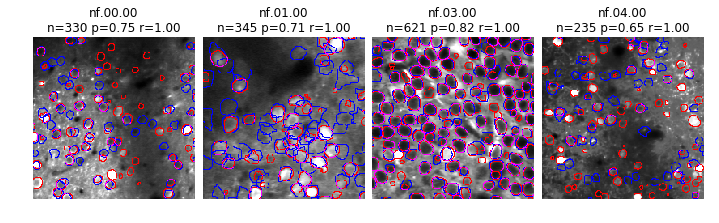

In [20]:
# Figure: mean summaries of training sequences with outlined ground-truth and predicted neurons.
# Use the raw masks from HDF5 files and make predictions using the stored model + weights.

# Load datasets.
dsids = ['neurofinder.00.00', 'neurofinder.01.00', 'neurofinder.03.00', 'neurofinder.04.00']
crops = [(100, 300, 50, 250), (100, 300, 50, 250), (100, 300, 50, 250), (100, 300, 50, 250)]
datasets = nf_load_hdf5(dsids)

# Predict.
model = UNet2DSummary(cpdir='/home/kzh/tmp')
Mp, names = model.predict(datasets, MODEL_PATH)
fig, _ = plt.subplots(1, 4, figsize=(12,4))
for ax, dsp, crop, mp in zip(fig.axes, datasets, crops, Mp):
    fp = h5py.File(dsp)
    name = fp.attrs['name'].replace('neurofinder', 'nf')
    nb_neurons = fp.get('masks/raw').shape[0]
    
    # Metrics before cropping.
    mp = mp.round()
    p, r, i, e, c = nf_mask_metrics(fp.get('masks/max')[...], mp)
    
    # Crop before outlining.
    y0, y1, x0, x1 = crop
    s = fp.get('series/mean')[y0:y1,x0:x1]
    m = fp.get('masks/raw')[:,y0:y1,x0:x1]
    mp = mp[y0:y1,x0:x1]
    
    # Outline.
    msks = list(m) + [mp]
    clrs = ['blue'] * nb_neurons + ['red']
    outlined = mask_outlines(s, msks, clrs)
    
    ax.axis('off')
    ax.imshow(outlined)
    ax.set_title('%s\nn=%d p=%.2lf r=%.2lf' % (name, nb_neurons, p, r))
    fp.close()
    
plt.subplots_adjust(left=None, wspace=0.05, hspace=0, right=None)
plt.savefig('dlmia_fig_nf_train_outlined.png', dpi=60)
plt.savefig('dlmia_fig_nf_train_outlined.pdf', mode='pdf', dpi=100)

sj.010517
sj.010517: prec=0.29, reca=1.00, f=0.45
sj.120116
sj.120116: prec=0.30, reca=1.00, f=0.47


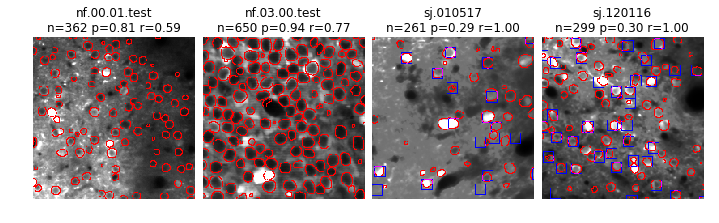

In [24]:
# Figure: predictions on Neurofinder test set and St. Jude datasets.
# NF datasets have predicted outlines and SJ have ground-truth bounding boxes and predicted outlines.

# (name, outlined image, number of neurons, precision, recall)
fig_data = []

# Neurofinder datasets.
names = ['neurofinder.00.01.test', 'neurofinder.03.00.test']
crops = [(100,300,200,400), (100,300,200,400)]
P, R = [.81,.94], [.59, .77]

datasets = nf_load_hdf5(names)
model = UNet2DSummary(cpdir='/home/kzh/tmp')
Mp, names = model.predict(datasets, MODEL_PATH)

for dsp, crop, mp, p, r in zip(datasets, crops, Mp, P, R):
    fp = h5py.File(dsp)
    name = fp.attrs['name'].replace('neurofinder', 'nf')
    y0, y1, x0, x1 = crop
    s = fp.get('series/mean')[y0:y1,x0:x1]
    mp = mp.round()
    nb_neurons = np.max(measure.label(mp)) - 1
    mp = mp[y0:y1,x0:x1]
    outlined = mask_outlines(s, [mp], ['red'])
    fig_data.append((name, outlined, nb_neurons, p, r))
    fp.close()

# St. Jude datasets.
datasets = ['../data/neurons_sj/sj.neurons.010517.hdf5', '../data/neurons_sj/sj.neurons.120116.hdf5']
crops = [(300,500,300,500), (250,450,200,400)]
Mp, names = model.predict(datasets, MODEL_PATH)

for dsp, crop, mp in zip(datasets, crops, Mp):
    fp = h5py.File(dsp)
    mp = mp.round()
    name = fp.attrs['name']
    print(name)
    p, r, i, e, c = nf_mask_metrics(fp.get('masks/max')[...], mp)
    print('%s: prec=%.2lf, reca=%.2lf, f=%.2lf' % (name, p, r, c))
    y0, y1, x0, x1 = crop
    s = fp.get('series/mean')[y0:y1,x0:x1]
    m = fp.get('masks/raw')[:,y0:y1,x0:x1]
    nb_neurons = np.max(measure.label(mp)) - 1
    mp = mp[y0:y1,x0:x1]
    msks = list(m) + [mp]
    clrs = ['blue'] * len(m) + ['red']
    outlined = mask_outlines(s, msks, clrs)
    fig_data.append((name, outlined, nb_neurons, p, r))
    fp.close()

# Create the figure.
show_idxs = [0, 1, 2, 3]
fig, _ = plt.subplots(1, len(show_idxs), figsize=(12,4))
for ax, idx in zip(fig.axes, show_idxs):
    ax.imshow(fig_data[idx][1])
    ax.axis('off')
    ax.set_title('%s\nn=%d p=%.2lf r=%.2lf' % (fig_data[idx][0], fig_data[idx][2], fig_data[idx][3], fig_data[idx][4]))
    
plt.subplots_adjust(left=None, wspace=0.05, hspace=0, right=None)
plt.savefig('dlmia_fig_test_outlined.png', dpi=60)
plt.savefig('dlmia_fig_test_outlined.pdf', mode='pdf', dpi=100)
plt.show()

In [ ]:
# K-Means summary images.
# dspaths = nf_load_hdf5('neurofinder.00.00')
# for dsp in dspaths:
#     fp = h5py.File(dsp)
#     series = fp.get('series/raw')[:, :320, :320]
#     summary_mean = fp.get('series/mean')[:320, :320]
#     mask = fp.get('masks/max')[:320, :320]
#     %time summary_kmns = series_kmeans_summary(series, k=8)
#     order = sorted(list(range(len(summary_kmns))), key=lambda i: np.sum(np.abs(summary_mean - summary_kmns[i])))
#     fig, axes = plt.subplots(1, 1 + len(summary_kmns), figsize=(30, 8))
#     for i in range(0, 1 + len(summary_kmns)):
#         axes[i].axis('off')
#         if i == 0:
#             outlined = mask_outlines(summary_mean.astype(np.float64), [mask], ['blue'])
#             axes[i].imshow(outlined, cmap='gray')
#             axes[i].set_title('Mean Summary')
#         else:
#             axes[i].imshow(summary_kmns[order[i-1]], cmap='gray')
#             axes[i].set_title('Centroid %d' % i)
#     plt.show()

In [11]:
# K-Means summary images. Compute and save temporary HDF5 files containing kmeans summaries.
# Using a 200 x 200 window from the center of the series for efficiency.
k, wdw_h, wdw_w = 10, 200, 200
hdf5_paths = nf_load_hdf5('all_train')[:5]
for path in hdf5_paths:
    print('started %s' % path)
    fp = h5py.File(path)
    name = fp.attrs['name']
    t, h, w = fp.get('series/raw').shape
    cy, cx = int(h / 2), int(w / 2)
    y0, y1 = cy - (wdw_h // 2), cy + (wdw_h // 2)
    x0, x1 = cx - (wdw_w // 2), cx + (wdw_w // 2)
    s_raw = fp.get('series/raw')[:,y0:y1,x0:x1]
    s_mean = fp.get('series/mean')[y0:y1,x0:x1]
    fp.close()
    
    path = 'kmeans_%s_%d_%d_%d.hdf5' % (name, k, (y1 - y0), (x1 - x0))
    if not os.path.exists(path): 
        fp = h5py.File(path, 'w')
        fp.attrs['name'] = name
        fp.attrs['y0'] = y0
        fp.attrs['y1'] = y1
        fp.attrs['x0'] = x0
        fp.attrs['x1'] = x1
        s_kmns = fp.create_dataset('series/kmns', (k, y1 - y0, x1 - x0), dtype='float16')
        s_kmns[...] = series_kmeans_summary(s_raw, k=k)
        print(s_kmns.shape)
        fp.close()
    
    print('%s finished' % path)

started /media/alex/data_224ssd/deep-calcium/datasets/neurons_nf/neurofinder.00.00/dataset.hdf5
(10, 200, 200)
kmeans_neurofinder.00.00_10_200_200.hdf5 finished
started /media/alex/data_224ssd/deep-calcium/datasets/neurons_nf/neurofinder.00.01/dataset.hdf5
(10, 200, 200)
kmeans_neurofinder.00.01_10_200_200.hdf5 finished
started /media/alex/data_224ssd/deep-calcium/datasets/neurons_nf/neurofinder.00.02/dataset.hdf5
(10, 200, 200)
kmeans_neurofinder.00.02_10_200_200.hdf5 finished
started /media/alex/data_224ssd/deep-calcium/datasets/neurons_nf/neurofinder.00.03/dataset.hdf5
(10, 200, 200)
kmeans_neurofinder.00.03_10_200_200.hdf5 finished
started /media/alex/data_224ssd/deep-calcium/datasets/neurons_nf/neurofinder.00.04/dataset.hdf5
(10, 200, 200)
kmeans_neurofinder.00.04_10_200_200.hdf5 finished


kmeans_neurofinder.00.00_10_200_200.hdf5


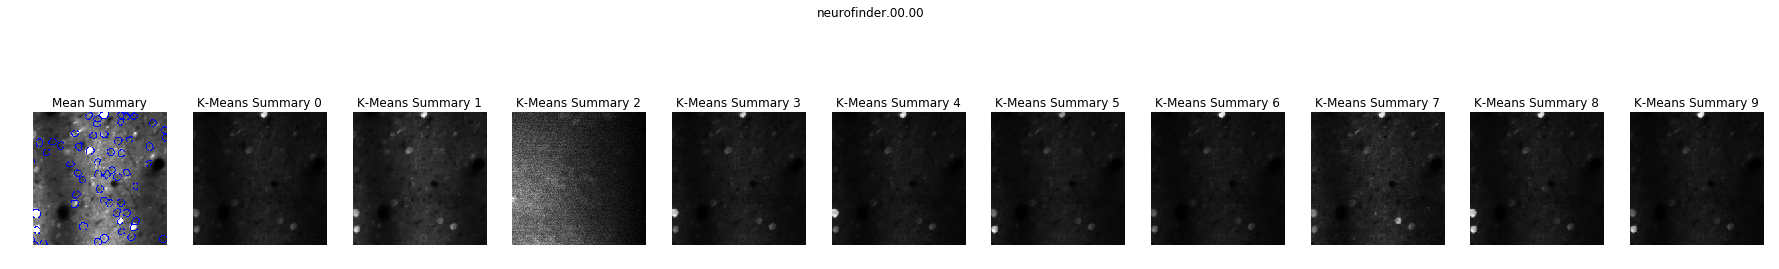

kmeans_neurofinder.00.01_10_200_200.hdf5


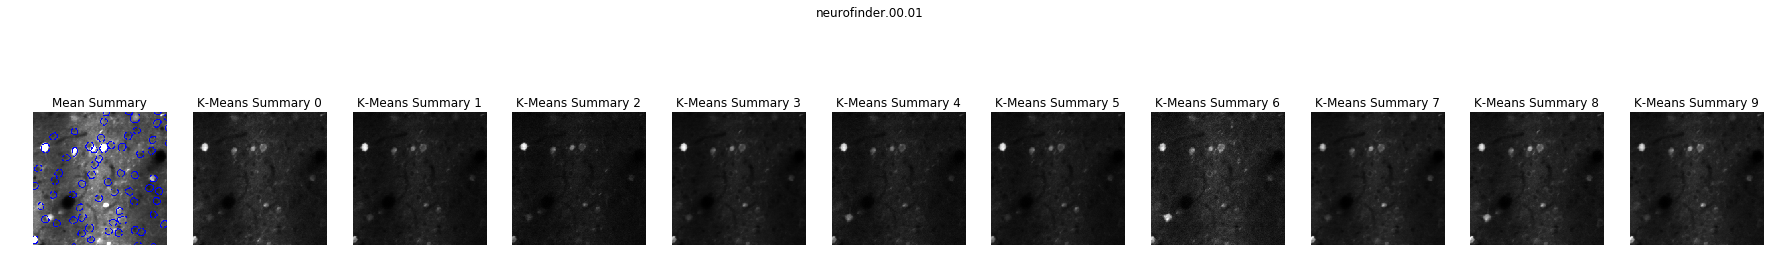

kmeans_neurofinder.00.02_10_200_200.hdf5


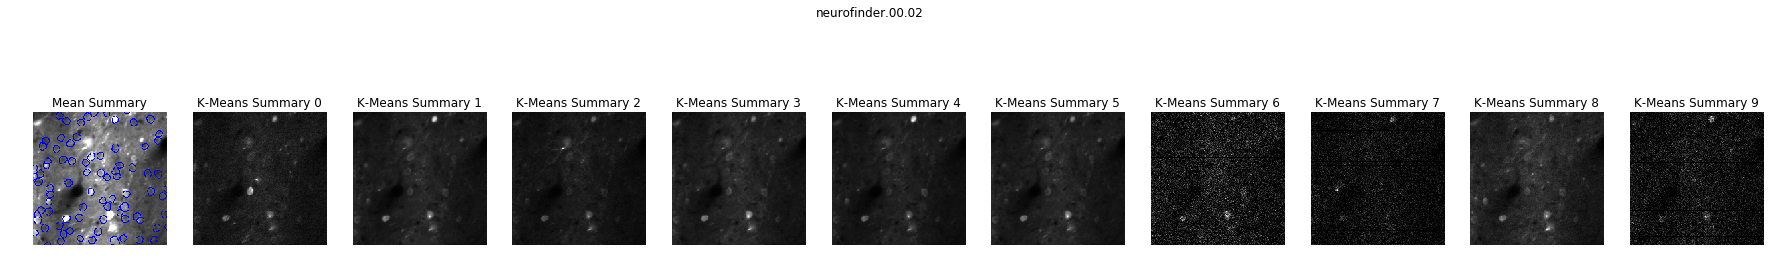

kmeans_neurofinder.00.03_10_200_200.hdf5


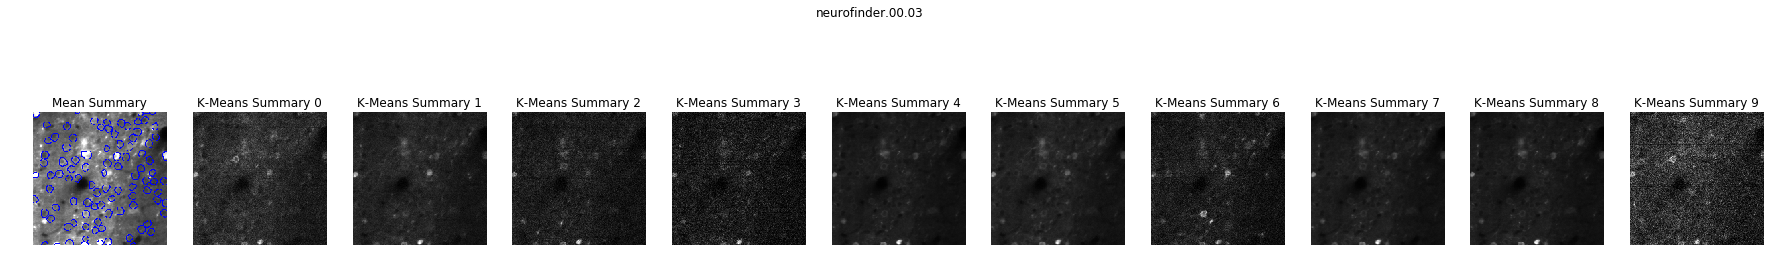

kmeans_neurofinder.00.04_10_200_200.hdf5


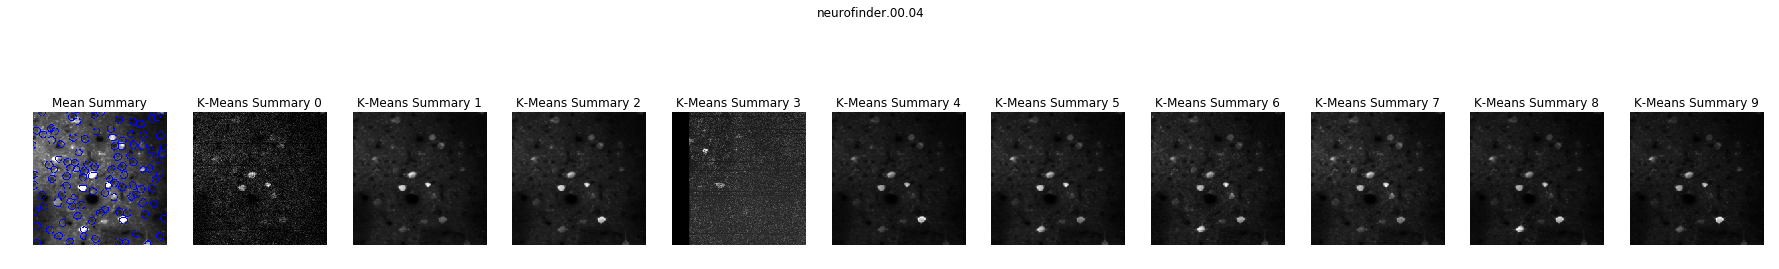

In [14]:
# K-means summary images: display the images alongside the corresponding mean summaries.
hdf5_paths = sorted(glob('kmeans_neurofinder*_10_*.hdf5'))
for path in hdf5_paths:
    print(path)
    fp = h5py.File(path)
    s_kmns = fp.get('series/kmns')[...]
    k = s_kmns.shape[0]
    name = fp.attrs['name']
    y0, y1, x0, x1 = fp.attrs['y0'], fp.attrs['y1'], fp.attrs['x0'], fp.attrs['x1']
    fp.close()
    
    [path] = nf_load_hdf5(name)
    fp = h5py.File(path)
    m_raw = fp.get('masks/raw')[:,y0:y1,x0:x1]
    s_mean = fp.get('series/mean')[y0:y1,x0:x1]
    fp.close()
    
    order = np.arange(k)
    order = sorted(order, key=lambda i: np.sum(np.abs(s_mean - s_kmns[i])))
    
    fig, axes = plt.subplots(1, 1 + k, figsize=((1 + k * 3), 5))
    for i, ax in enumerate(axes):
        ax.axis('off')
        if i == 0:
            outlined = mask_outlines(s_mean, m_raw, ['blue'] * len(m_raw))
            ax.imshow(outlined, cmap='gray')
            ax.set_title('Mean Summary')
        else:
            ax.imshow(s_kmns[order[i - 1]].astype(np.float32), cmap='gray')
            ax.set_title('K-Means Summary %d' % (i - 1))
    plt.suptitle(name)
    plt.savefig('kmeans_%s.png' % name, dpi=250, bbox_inches='tight', pad_inches=0)
    plt.show()

kmeans_neurofinder.00.00_10_200_200.hdf5


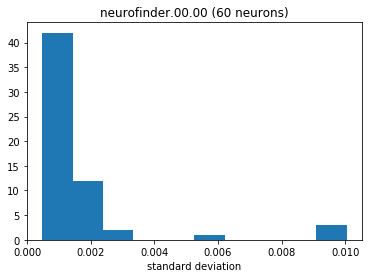

kmeans_neurofinder.00.01_10_200_200.hdf5


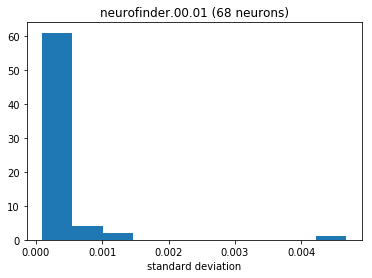

kmeans_neurofinder.00.02_10_200_200.hdf5


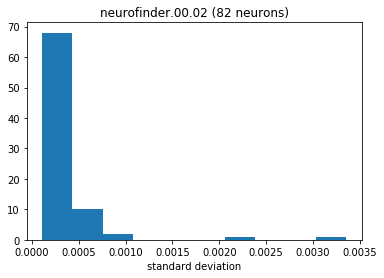

kmeans_neurofinder.00.03_10_200_200.hdf5


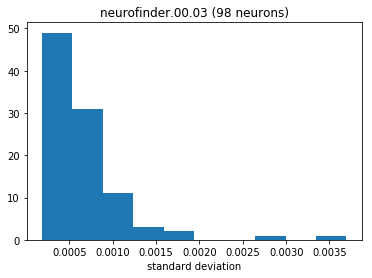

kmeans_neurofinder.00.04_10_200_200.hdf5


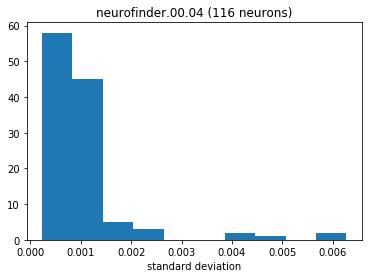

In [12]:
# K-means summary images: compute the mean intensity of each neuron at each of k summaries.
# Plot a histogram of the standard deviations for each series. This should give an idea of
# how much the neurons in each series vary across the kmeans summaries.
hdf5_paths = sorted(glob('kmeans_neurofinder*_10_*.hdf5'))
for path in hdf5_paths:
    print(path)
    fp = h5py.File(path)
    s_kmns = fp.get('series/kmns')[...]
    k = s_kmns.shape[0]
    name = fp.attrs['name']
    y0, y1, x0, x1 = fp.attrs['y0'], fp.attrs['y1'], fp.attrs['x0'], fp.attrs['x1']
    fp.close()
    
    [path] = nf_load_hdf5(name)
    fp = h5py.File(path)
    m_raw = fp.get('masks/raw')[:,y0:y1,x0:x1]
    s_mean = fp.get('series/mean')[y0:y1,x0:x1]
    fp.close()
    
    stdvs = []
    for m in m_raw:
        if np.sum(m) == 0:
            continue
        yy, xx = np.where(m == 1)
        means = [np.mean(s_kmns[i,yy,xx] / 2**16) for i in range(k)]
        stdvs.append(np.std(means))
    
    plt.title('%s (%d neurons)' % (name, len(stdvs)))
    plt.hist(stdvs)
    plt.xlabel('standard deviation')
    plt.show()

3000it [00:15, 199.53it/s]


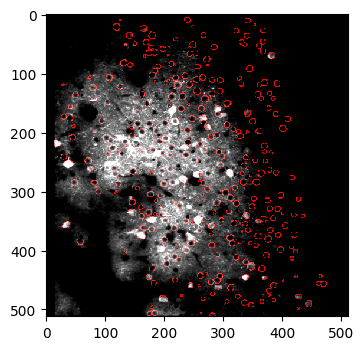

3000it [00:14, 209.78it/s]
3000it [00:14, 207.93it/s]
3000it [00:14, 209.77it/s]
3000it [00:14, 206.26it/s]

5 iterations, 8057 frames / minute


In [35]:
# How fast are predictions? Delete the hdf5 dataset before making predictions.
from time import time
fpms = []
nb_iters = 5
for i in xrange(nb_iters):
    tic = time()
    remove('../data/neurofinder.00.00.test/dataset.hdf5')
    ds = nf_load_hdf5('neurofinder.00.00.test')
    model = UNet2DSummary()
    Mp = model.predict(ds, MODEL_PATH, save=(i==0))
    fp = h5py.File(ds[0])
    nb_frames = fp.get('series/raw').shape[0]
    nb_sec = time() - tic
    fpm = int(nb_frames * 1. / (nb_sec / 60))
    fpms.append(fpm)
    if i == 0:
        plt.imshow(imread('/home/kzh/tmp/neurofinder.00.00.test_mp.png'), cmap='gray')
        plt.show()
    fp.close()
    
print('%d iterations, %d frames / minute' % (nb_iters, np.mean(fpms)))